In [2]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import ipywidgets as widgets


import seaborn as sns

import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [4]:
import hamiltorch

In [5]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [112]:
gt_distribution = torch.distributions.Normal(0, 1)

# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))

samples = sample_gt(1000)

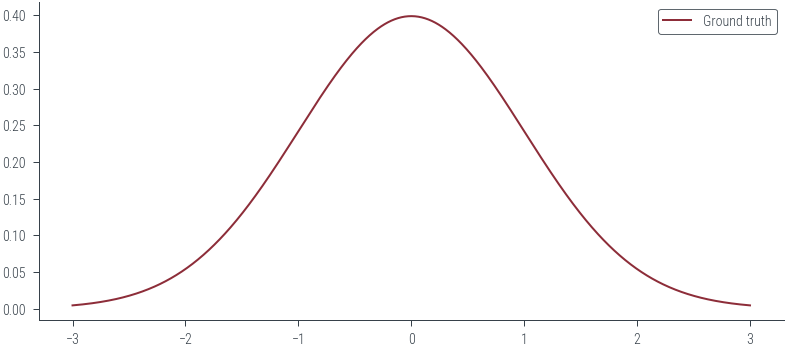

In [113]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label='Ground truth')
plt.legend()

In [114]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x)

In [115]:
logprob(torch.tensor([0.0]))

tensor([-0.9189])

In [116]:
# Initial state
x0 = torch.tensor([0.0]).to(device)
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

In [117]:
params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,  
                               num_samples=num_samples, step_size=step_size, 
                               num_steps_per_sample=num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:21 | 0d:00:00:00 | #################### | 5000/5000 | 234.27       
Acceptance Rate 0.99


In [13]:
params_hmc = torch.tensor(params_hmc)

In [14]:
def run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample):
    params_hmc = hamiltorch.sample(log_prob_func=logprob, params_init=x0,
                                    num_samples=num_samples, step_size=step_size,
                                    num_steps_per_sample=num_steps_per_sample)
    return torch.stack(params_hmc)


params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 5000/5000 | 694.57       
Acceptance Rate 0.99


In [15]:
params_hmc.shape

torch.Size([5000, 1])

Text(0, 0.5, 'Parameter value')

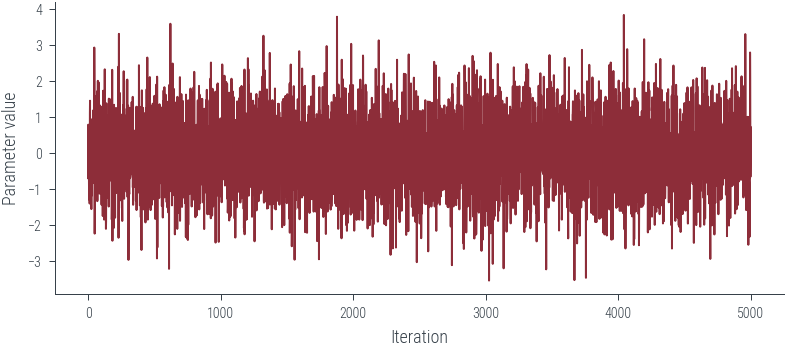

In [16]:
# Trace plot
plt.plot(params_hmc, label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')

Text(0, 0.5, 'Parameter value')

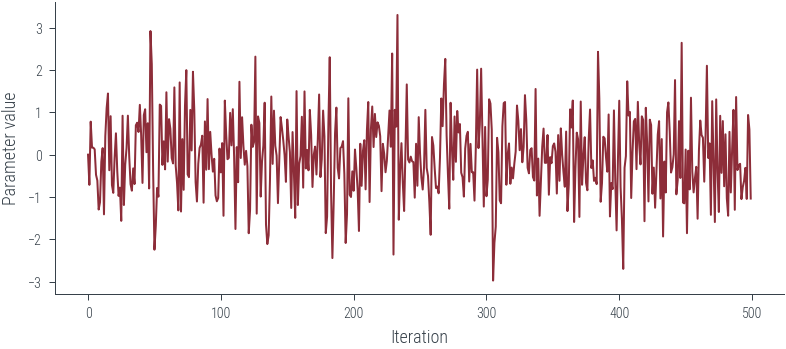

In [17]:
# view first 500 samples
plt.plot(params_hmc[:500], label='Trace')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')


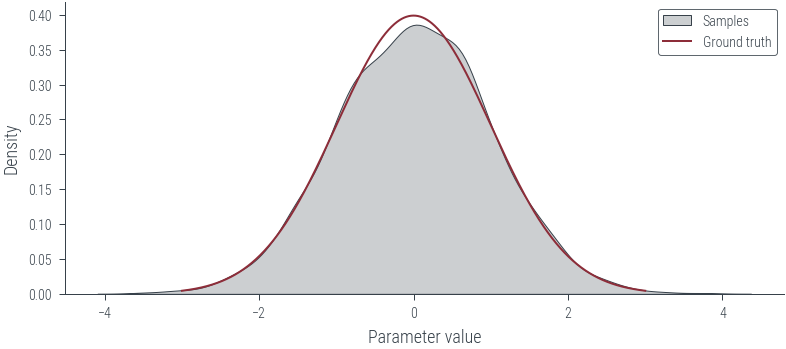

In [18]:
# KDE plot
import seaborn as sns
plt.figure()
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

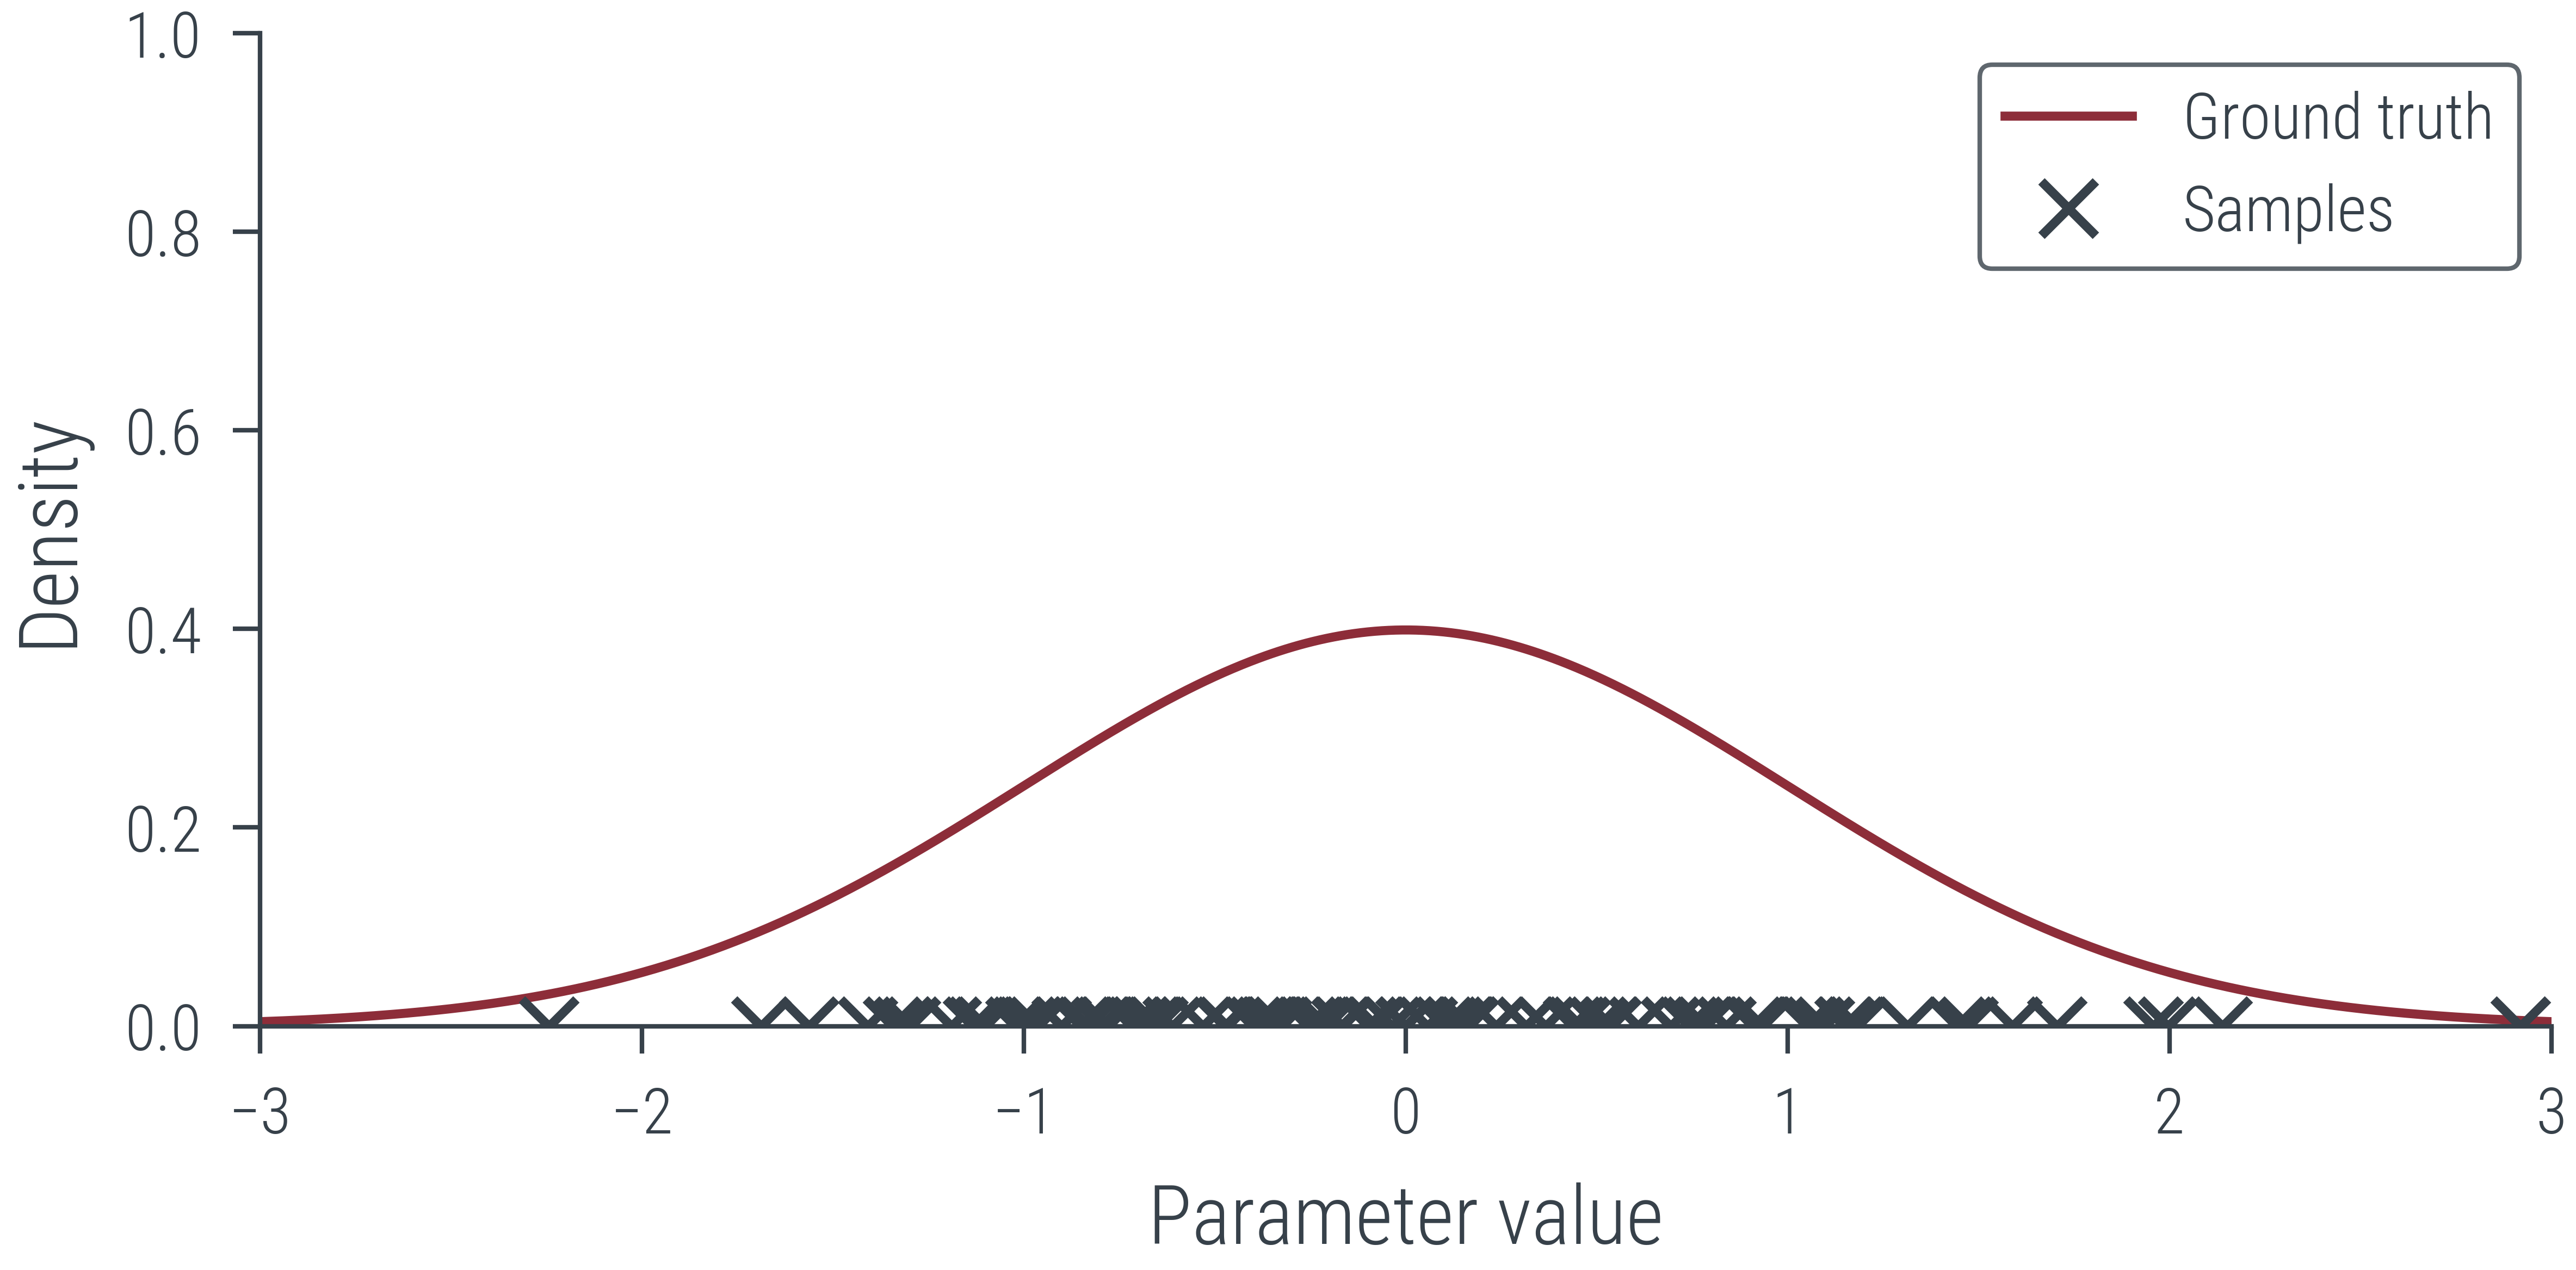

In [19]:
# Create MP4 HTML5 video showing sampling process

def create_mp4_samples(samples, x_lin, y_lin, filename='samples.mp4', dpi=600):
    fig, ax = plt.subplots(figsize=(4,2), dpi=dpi)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Density')
    ax.plot(x_lin, y_lin, label='Ground truth')
    ax.legend()

    # Add a "x" marker to the plot for each sample at y=0
    x_marker, = ax.plot([], [], 'x', color='C1', label='Samples')
    ax.legend()

    def init():
        x_marker.set_data([], [])
        return x_marker,

    def animate(i):
        x_marker.set_data(samples[:i], torch.zeros(i))
        return x_marker,

    anim = FuncAnimation(fig, animate, init_func=init,
                                     frames=len(samples), interval=20, blit=True)
    anim.save(filename, dpi=dpi, writer='ffmpeg')

create_mp4_samples(params_hmc[:100], x_lin, y_lin, filename='../figures/sampling/mcmc/normal.mp4', dpi=600)

In [68]:
from IPython.display import Video
Video('../figures/sampling/mcmc/normal.mp4', width=400)

<AxesSubplot:ylabel='Density'>

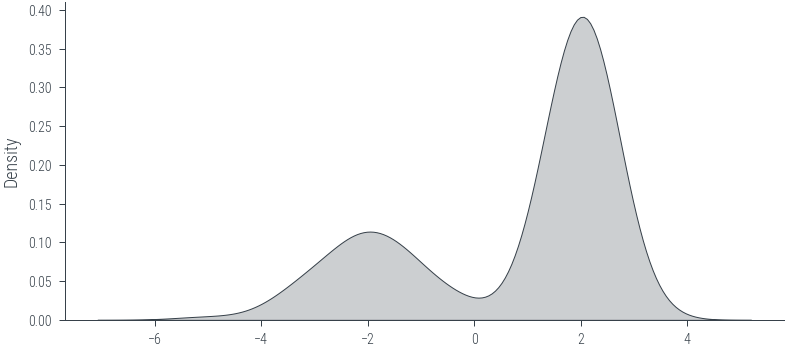

In [20]:
# sample from Mixture of Gaussians

mog = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.3, 0.7])),
    component_distribution=dist.Normal(torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 0.5]))
)

samples = mog.sample((1000,))
sns.kdeplot(samples.numpy(), label='Samples', shade=True, color='C1')

In [21]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return mog.log_prob(x)

logprob(torch.tensor([0.0]))

tensor([-4.1114])

In [22]:
params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 461.20       
Acceptance Rate 0.99


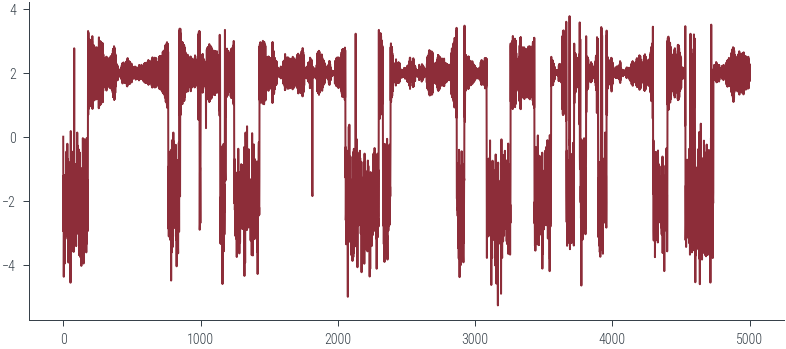

In [23]:
# Trace plot
plt.plot(params_hmc, label='Trace')

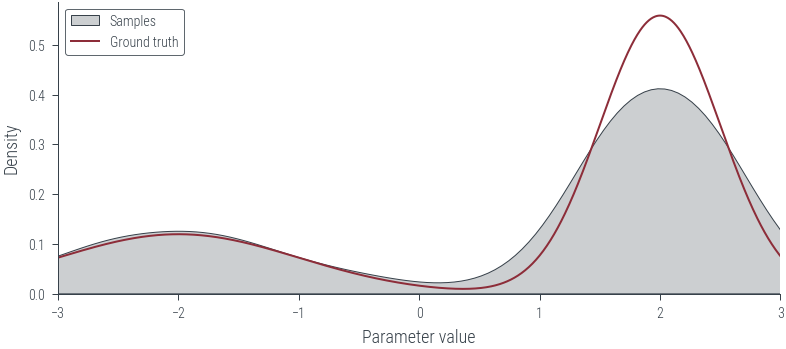

In [24]:
y_lin = torch.exp(mog.log_prob(x_lin))


# KDE plot
plt.figure()
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
# Limit KDE plot to range of ground truth
plt.xlim(-3, 3)
plt.plot(x_lin, y_lin, label='Ground truth')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()

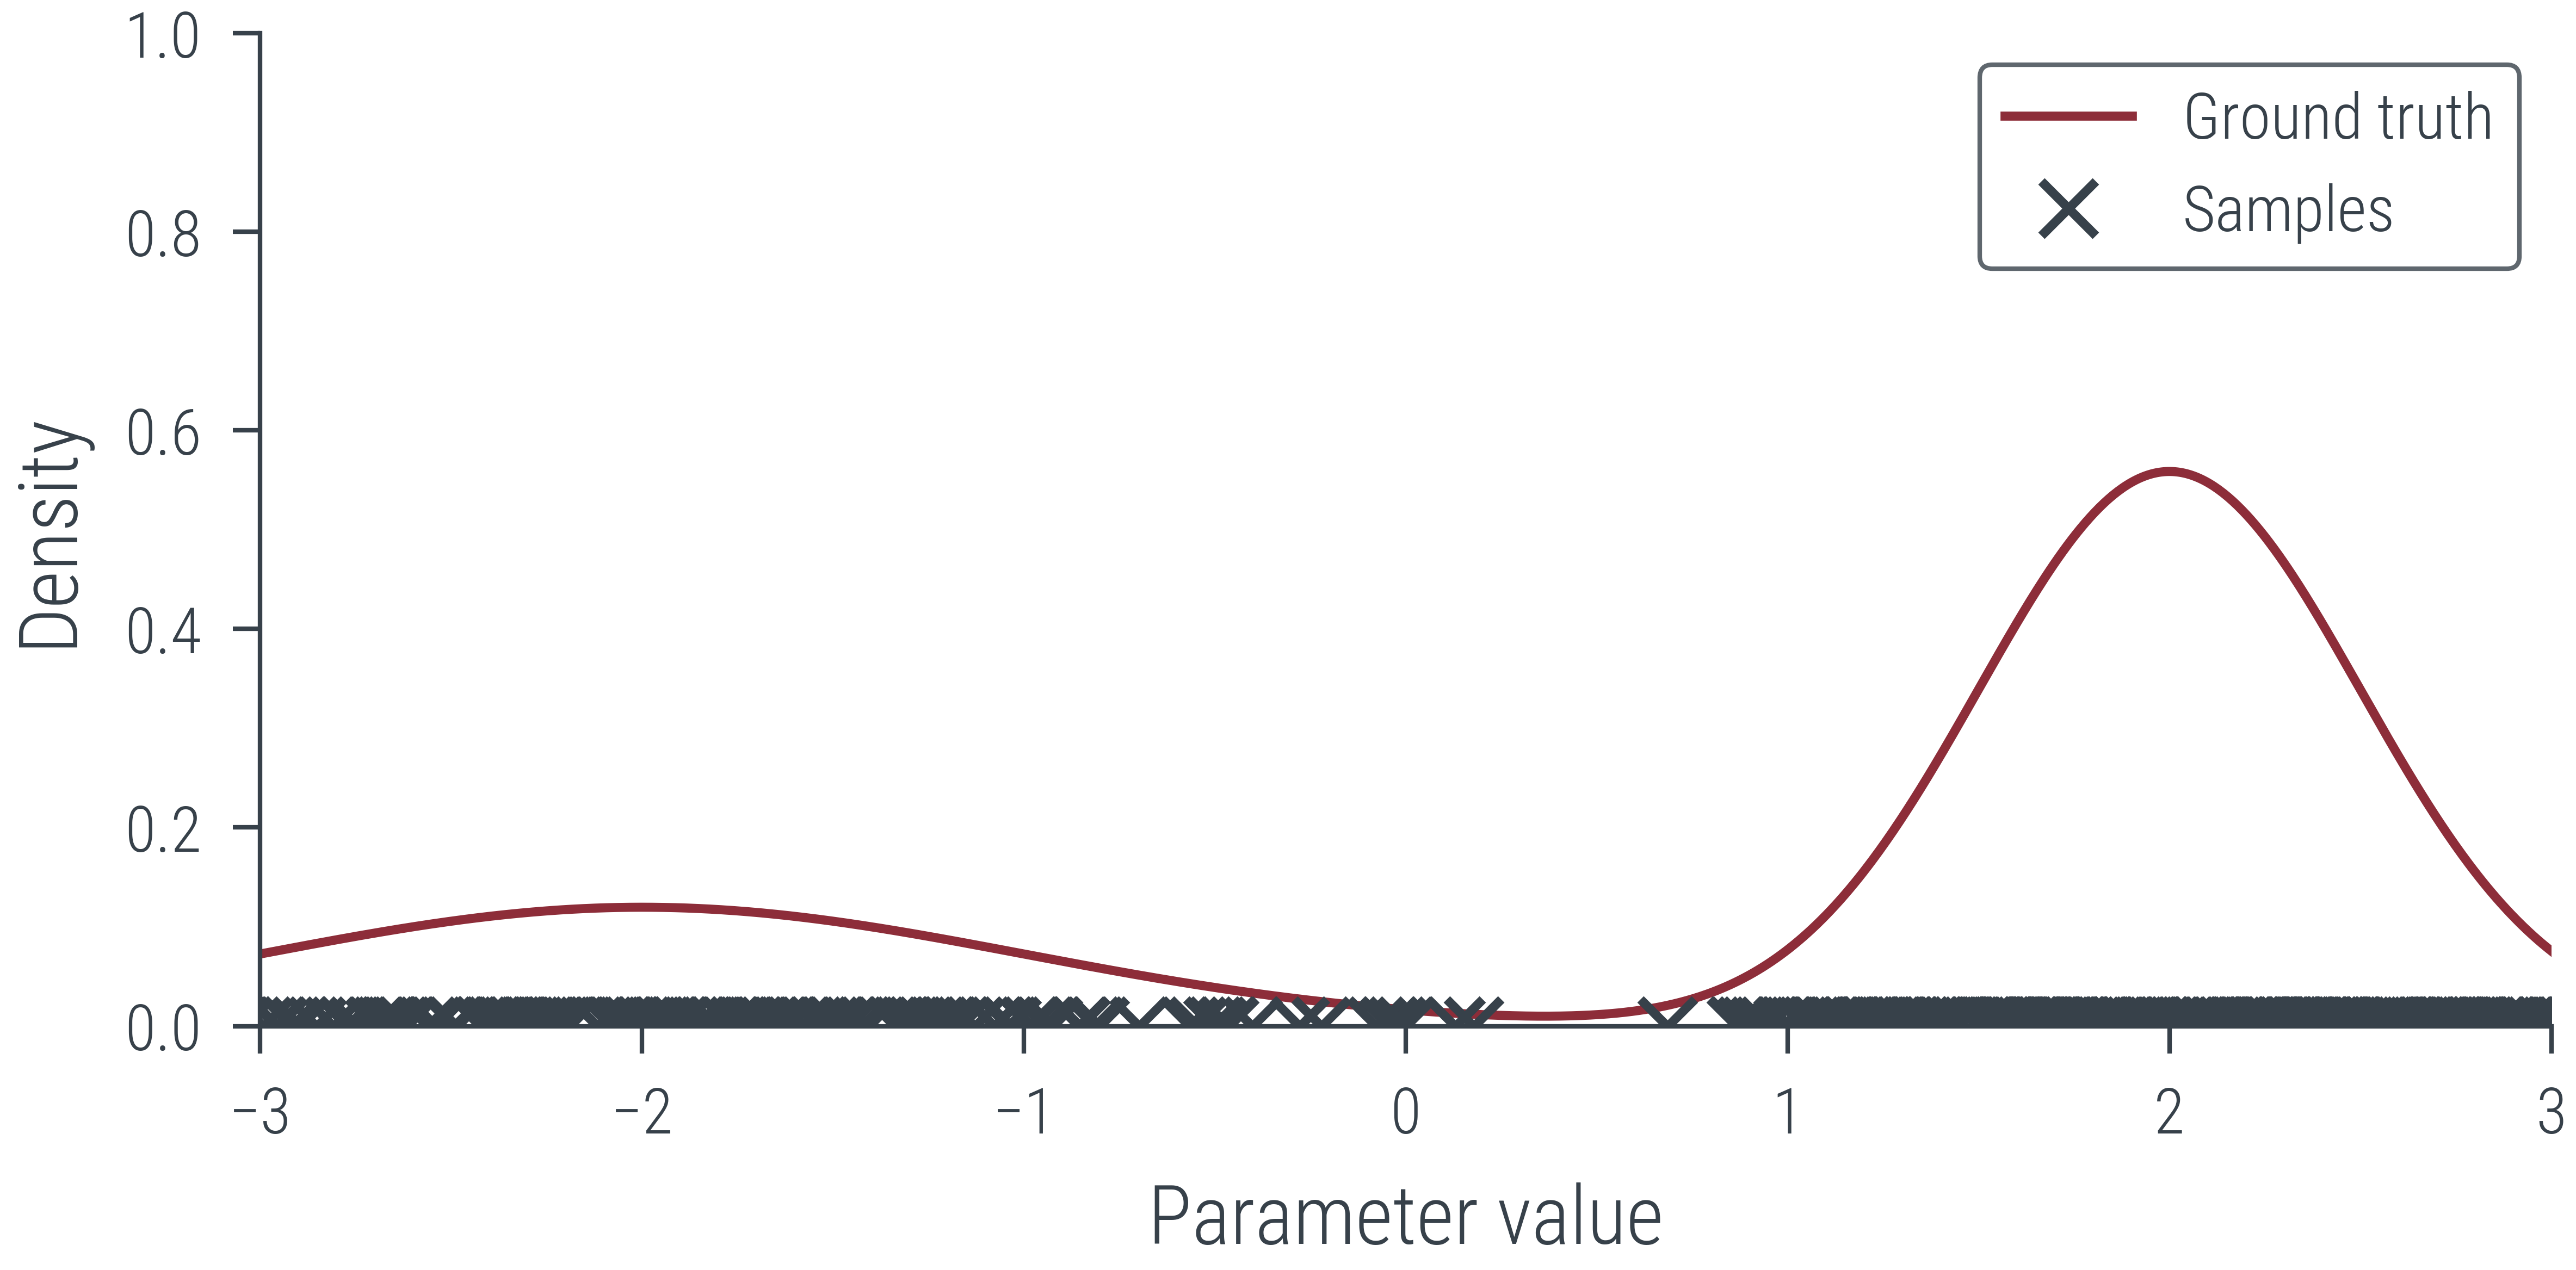

In [66]:
# Create MP4 HTML5 video showing sampling process
create_mp4_samples(params_hmc[:500], x_lin, y_lin, filename='../figures/sampling/mcmc/mog.mp4', dpi=600)

In [69]:
Video('../figures/sampling/mcmc/mog.mp4', width=400)

### Sampling from an unnormalized distribution

In [25]:
def p_tilde(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x).exp()*Z

def p_tilde_log_prob(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2*np.pi))
    return dist.Normal(0, 1).log_prob(x) + torch.log(Z)

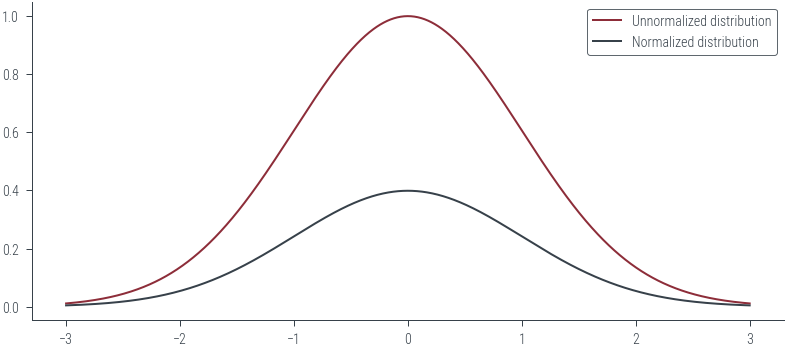

In [26]:
# Plot unnormalized distribution
x_lin = torch.linspace(-3, 3, 1000)
y_lin = p_tilde(x_lin)
plt.plot(x_lin, y_lin, label='Unnormalized distribution')
# Plot normalized distribution
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution')
plt.legend()

In [27]:
# HMC over unnormalized distribution

# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return p_tilde_log_prob(x)

In [28]:
# HMC
params_hmc = run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 486.30       
Acceptance Rate 0.99


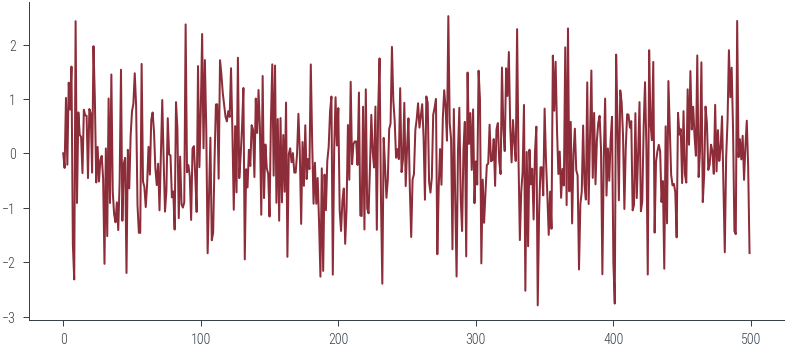

In [29]:
# Trace plot
plt.plot(params_hmc[:500], label='Trace')

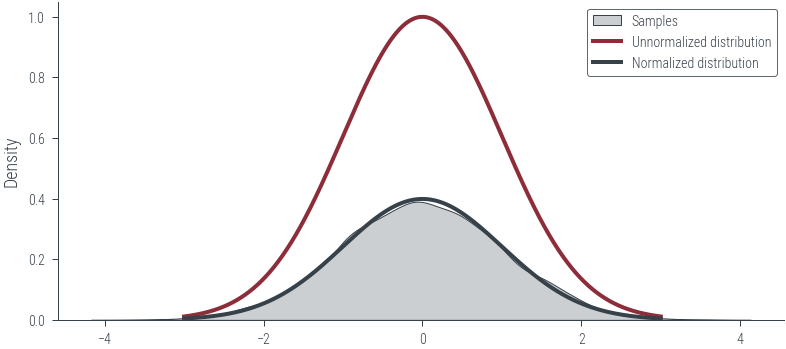

In [30]:
# KDE plot
sns.kdeplot(params_hmc.ravel().detach().numpy(), label='Samples', shade=True, color='C1')
plt.plot(x_lin, y_lin, label='Unnormalized distribution', lw=2)
plt.plot(x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label='Normalized distribution', lw=2)
plt.legend()

### Coin Toss

#### Working with probabilities

In [31]:
prior = dist.Beta(1, 1)
data = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0])
n = len(data)

def log_prior(theta):
    return prior.log_prob(theta)

def log_likelihood(theta):
    return dist.Bernoulli(theta).log_prob(data).sum()

def log_joint(theta):
    return log_prior(theta) + log_likelihood(theta)

In [32]:
try:
    params_hmc_theta = run_hmc(log_joint, torch.tensor([0.5]), 5000, 0.3, 5)
except Exception as e:
    print(e)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Expected value argument (Tensor of shape (1,)) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
tensor([-0.5696], requires_grad=True)


#### Working with logits

In [33]:
# Let us work instead with logits
def log_prior(logits):
    return prior.log_prob(torch.sigmoid(logits)).sum()

def log_likelihood(logits):
    return dist.Bernoulli(logits=logits).log_prob(data).sum()

def log_joint(logits):
    return (log_prior(logits) + log_likelihood(logits))

In [34]:
params_hmc_logits = run_hmc(log_joint, torch.tensor([0.0]), 1000, 0.3, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 274.86       
Acceptance Rate 0.99


Text(0.5, 0, 'Iteration')

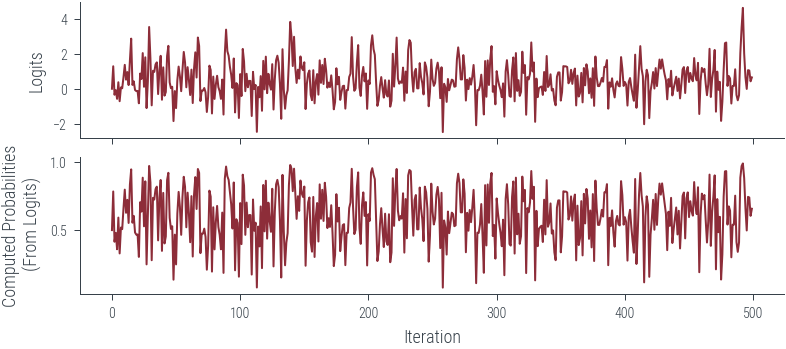

In [83]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(params_hmc_logits[:500], label='Trace for logits')
ax[1].plot(torch.sigmoid(params_hmc_logits[:500]), label='Trace for probabilities')
ax[0].set_ylabel('Logits')
ax[1].set_ylabel('Computed Probabilities\n (From Logits)')
ax[1].set_xlabel('Iteration')

In [35]:
# Create a function to update the KDE plot with the specified bw_adjust value
def update_kde_plot(bw_adjust):
    plt.clf()  # Clear the previous plot
    plt.hist(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), bins=100, density=True, label='Samples (Histogram)', color='C2', alpha=0.5, lw=1)
    sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples (KDE)', shade=False, color='C1', clip=(0, 1), bw_adjust=bw_adjust, lw=2)
    x_lin = torch.linspace(0, 1, 1000)
    y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
    plt.plot(x_lin, y_lin, label='True posterior')
    plt.legend()

# Create the slider widget for bw_adjust
bw_adjust_slider = widgets.FloatSlider(value=0.1, min=0.01, max=4.0, step=0.01, description='bw_adjust:')

# Create the interactive plot
interactive_plot = widgets.interactive(update_kde_plot, bw_adjust=bw_adjust_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=0.1, description='bw_adjust:', max=4.0, min=0.01, step=0.01), Output()…

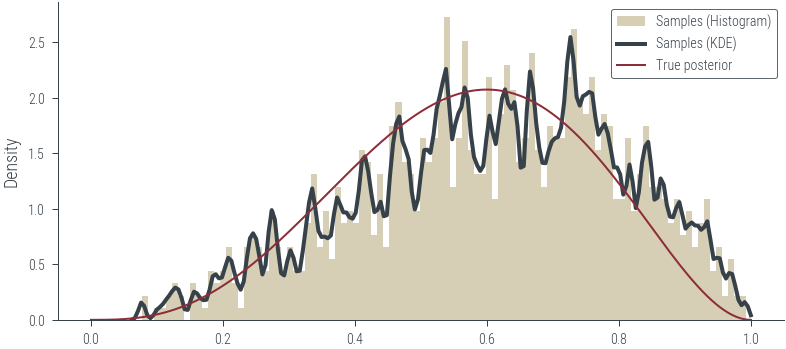

In [94]:

# Plot histogram of samples
plt.hist(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), bins=100, density=True, label='Samples (Histogram)', color='C2', alpha=0.5, lw=1 )

# Plot posterior KDE using seaborn but clip to [0, 1]
sns.kdeplot(torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(), label='Samples (KDE)', shade=False, color='C1', clip=(0, 1), bw_adjust=0.1, lw=2)
# True posterior
x_lin = torch.linspace(0, 1, 1000)
y_lin = dist.Beta(1+3, 1+2).log_prob(x_lin).exp()
plt.plot(x_lin, y_lin, label='True posterior')
plt.legend()a

Text(0, 0.5, 'y')

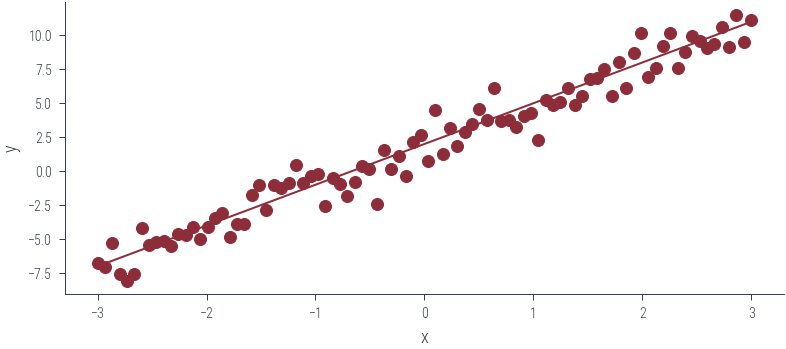

In [36]:
# Linear regression for 1 dimensional input using HMC

x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) *1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth')
plt.xlabel('x')
plt.ylabel('y')

In [37]:
# Esimate theta_0, theta_1 using HMC assuming noise variance is known to be 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()

def log_posterior(theta):
    return logprob(theta) + log_prior(theta)

In [44]:
params_hmc_lin_reg = run_hmc(log_posterior, torch.tensor([0.0, 0.0]), 1000, 0.05, 10)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 1000/1000 | 160.17       
Acceptance Rate 0.95


In [42]:
params_hmc_lin_reg = run_hmc(log_posterior, torch.tensor([theta_0_true, theta_1_true]), 1000, 0.05, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 265.64       
Acceptance Rate 0.93


In [39]:
params_hmc_lin_reg

tensor([[0.0000, 0.0000],
        [1.7289, 0.5213],
        [1.7485, 5.2386],
        ...,
        [1.7494, 2.8959],
        [1.7494, 2.8959],
        [1.7494, 2.8959]])

In [ ]:
par

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


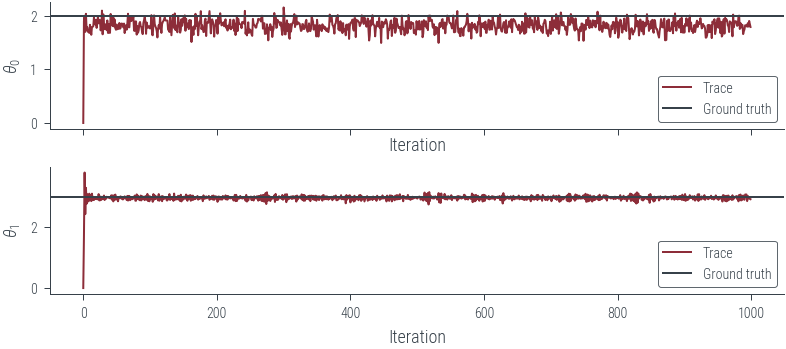

In [45]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color='C1', label='Ground truth')
    axes[i].legend()

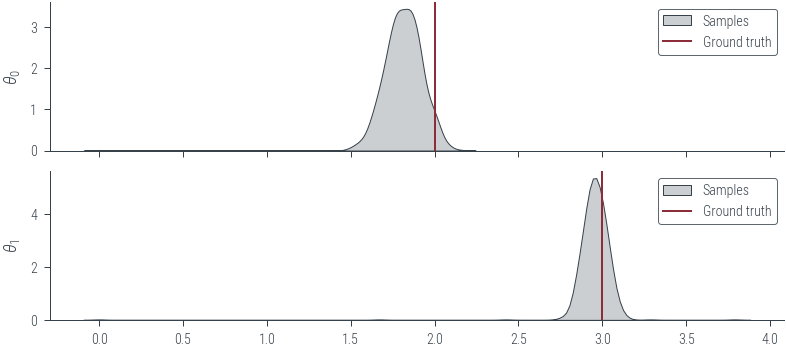

In [46]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color='C0', label='Ground truth')
    axes[i].legend()

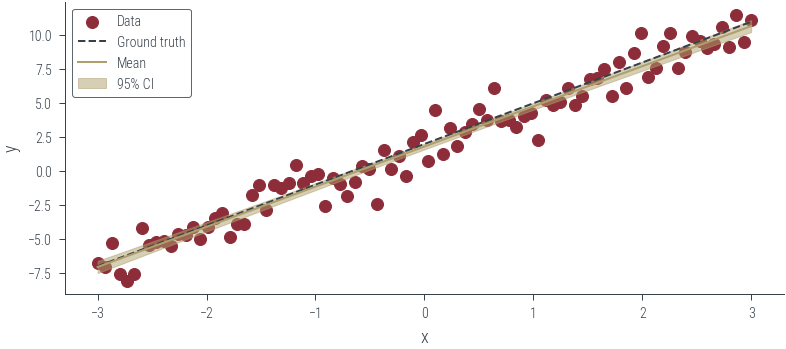

In [47]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc_lin_reg[100:].detach()
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[:, 1].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label='Mean', color='C2')
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')
plt.legend()

In [48]:
# Using a neural network with HMC

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [76]:
net = Net()
net

Net(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)

In [77]:
hamiltorch.util.flatten(net).shape

torch.Size([2])

In [86]:
theta_params = hamiltorch.util.flatten(net) + 1.0
theta_params

tensor([1.4463, 1.0916], grad_fn=<AddBackward0>)

In [87]:
temp = hamiltorch.util.unflatten(net, theta_params) 

In [88]:
net.state_dict()

OrderedDict([('fc1.weight', tensor([[0.4463]])),
             ('fc1.bias', tensor([0.0916]))])

In [89]:
hamiltorch.util.update_model_params_in_place(net, temp)

In [90]:
net.state_dict()

OrderedDict([('fc1.weight', tensor([[1.4463]])),
             ('fc1.bias', tensor([1.0916]))])

In [72]:
params_init = theta_params.clone().detach()
params_init

tensor([0.3320, 0.1773])

In [73]:
params_list =  hamiltorch.util.unflatten(net, theta_params)


TypeError: 'list' object is not callable

In [101]:
def log_prior(theta):
    return dist.Normal(0, 0.1).log_prob(theta).sum()

def log_likelihood(theta):
    with torch.no_grad():
        params_list =  hamiltorch.util.unflatten(net, theta)
        hamiltorch.util.update_model_params_in_place(net, params_list)
        y_pred = torch.func.functional_call(net, dict(net.named_parameters()), x_lin.unsqueeze(1))
        #y_pred = net(x_lin.unsqueeze(1)).ravel()
        return dist.Normal(y_pred, 1).log_prob(y_lin).sum()

def log_joint(theta):
    return log_prior(theta) + log_likelihood(theta)

params_hmc = run_hmc(log_joint, params_init, 1000, 0.1, 5)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 | 242.56       
Acceptance Rate 0.02


In [96]:
params_hmc

tensor([[0.3320, 0.1773],
        [0.3320, 0.1773],
        [0.2501, 0.1376],
        ...,
        [0.0269, 0.6539],
        [0.0269, 0.6539],
        [0.0269, 0.6539]])

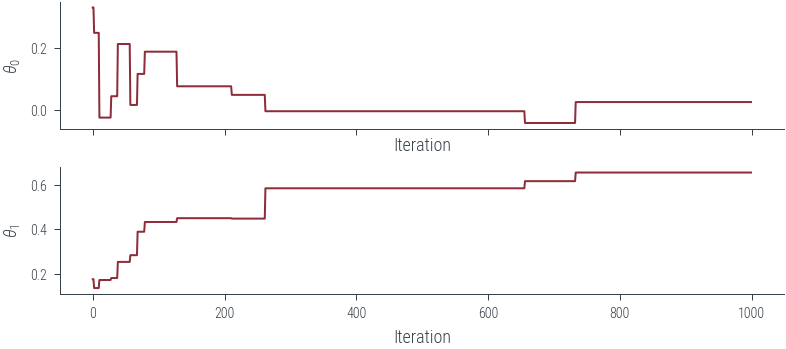

In [97]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label='Trace')
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel(fr'$\theta_{i}$')



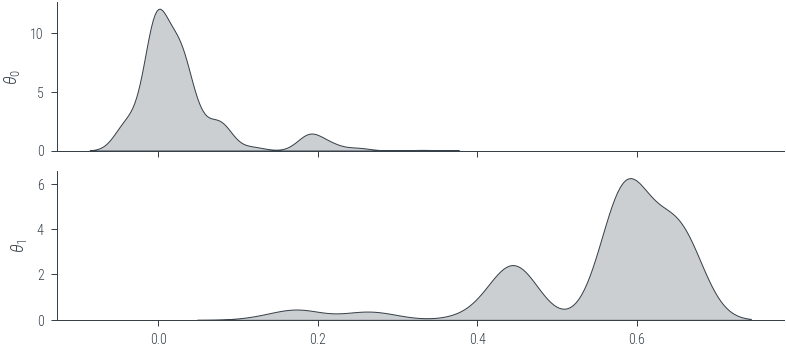

In [98]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(param_vals.detach().numpy(), label='Samples', shade=True, color='C1', ax=axes[i])
    axes[i].set_ylabel(fr'$\theta_{i}$')


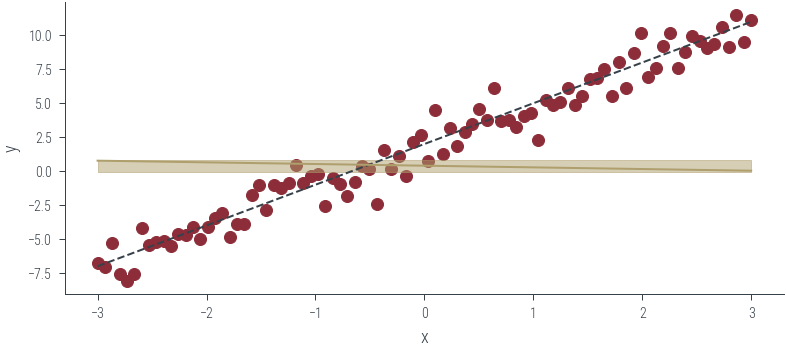

In [99]:
# Plot predictions
plt.figure()
plt.scatter(x_lin, y_lin, label='Data', color='C0')
plt.plot(x_lin, f(x_lin), label='Ground truth', color='C1', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc.detach()
with torch.no_grad():
    y_hat = net(x_lin.unsqueeze(1))

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.ravel(), label='Mean', color='C2')
# Plot 95% confidence interval
plt.fill_between(x_lin, y_hat.mean(axis=0) - 2 * y_hat.std(axis=0), y_hat.mean(axis=0) + 2 * y_hat.std(axis=0), alpha=0.5, label='95% CI', color='C2')


In [171]:
y_hat.ravel()

tensor([-3.2116, -3.1452, -3.0788, -3.0125, -2.9461, -2.8797, -2.8134, -2.7470,
        -2.6806, -2.6142, -2.5479, -2.4815, -2.4151, -2.3488, -2.2824, -2.2160,
        -2.1496, -2.0833, -2.0169, -1.9505, -1.8841, -1.8178, -1.7514, -1.6850,
        -1.6187, -1.5523, -1.4859, -1.4195, -1.3532, -1.2868, -1.2204, -1.1541,
        -1.0877, -1.0213, -0.9549, -0.8886, -0.8222, -0.7558, -0.6895, -0.6231,
        -0.5567, -0.4903, -0.4240, -0.3576, -0.2912, -0.2248, -0.1585, -0.0921,
        -0.0257,  0.0406,  0.1070,  0.1734,  0.2398,  0.3061,  0.3725,  0.4389,
         0.5052,  0.5716,  0.6380,  0.7044,  0.7707,  0.8371,  0.9035,  0.9699,
         1.0362,  1.1026,  1.1690,  1.2353,  1.3017,  1.3681,  1.4345,  1.5008,
         1.5672,  1.6336,  1.6999,  1.7663,  1.8327,  1.8991,  1.9654,  2.0318,
         2.0982,  2.1646,  2.2309,  2.2973,  2.3637,  2.4300,  2.4964,  2.5628,
         2.6292,  2.6955])

In [ ]:
# Now, solve the above using Hamiltorch's MCMC sample_model function

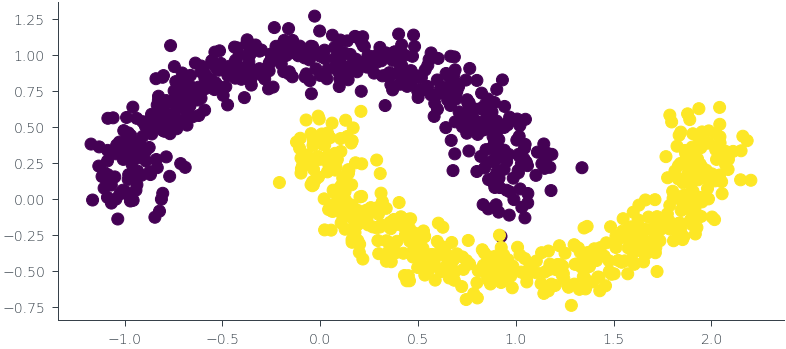

In [38]:
### Bayesian Logistic Regression

from sklearn.datasets import make_moons

# Generate data
x, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y)

x = torch.tensor(x).float()
y = torch.tensor(y).float()